## Time series generative model

This experiment follows the Section 4.1 of [Deep Signature Transforms](https://arxiv.org/pdf/1905.08494.pdf) paper.

In [1]:
import equinox as eqx
import jax
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from examples.nets import create_generative_net
from examples.utils.dataloader import DataLoader
from examples.utils.signature_normalization import normalize_signature
from jax import numpy as jnp
from jax import random as jrandom
from signax.module import SignatureTransform
from utils.brownian_motion import get_bm_noise
from utils.ornstein_uhlenbeck import get_ou_signal

### Parameter setup

In [2]:
random_seed = 1234
random_key = jrandom.PRNGKey(random_seed)

train_batch_size = 2**10
val_batch_size = 2**10
epochs = 1000
n_points = 100

train_key, eval_key, signal_key, model_key = jrandom.split(random_key, 4)

### Create data

In [3]:
train_dataset = get_bm_noise(
    n_points=n_points, num_samples=train_batch_size, random_key=train_key
)
eval_dataset = get_bm_noise(
    n_points=n_points, num_samples=val_batch_size, random_key=eval_key
)
signals = get_ou_signal(signal_key, train_batch_size, n_points)

Plot Ornstein-Uhlenbeck data

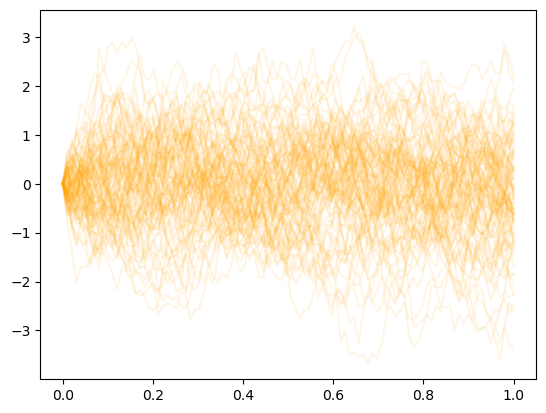

In [4]:
for sig_path in signals[:100]:
    plt.plot(*sig_path, "orange", alpha=0.1)

### Create model

In [5]:
signature_depth = 4
model = create_generative_net(2, key=model_key)

optim = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=1e-1),
)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

In [6]:
@eqx.filter_jit
def batch_normalize(batch_generator, batch_data):
    """Normalize signature from generated data"""
    return jax.vmap(
        lambda _batch: normalize_signature(
            batch_generator(_batch),
            signature_depth,
        )
    )(batch_data)

In [7]:
signature_transform = SignatureTransform(signature_depth)
normalized_signal_sigs = batch_normalize(
    signature_transform, signals.transpose(0, 2, 1)
)

In [8]:
@eqx.filter_jit
def predict(model_to_predict, path):
    path = model_to_predict(path).squeeze()
    timeline = jnp.linspace(0, 1, path.shape[0] + 1)
    path = jnp.stack([timeline, jnp.concatenate([jnp.array([0]), path])])
    path = path.transpose((1, 0))
    sig = signature_transform(path)

    return sig

In [9]:
def kernel(sigs1, sigs2):
    """Kernel function between two signatures.
    This will be used in computing maximum mean discrepancy (MMD)
    """
    return jnp.mean(jnp.matmul(sigs1, sigs2.transpose()))


t1 = kernel(normalized_signal_sigs, normalized_signal_sigs)

In [10]:
@eqx.filter_value_and_grad
def loss(model_to_train, paths):
    generated_sigs = batch_normalize(
        lambda path: predict(model_to_train, path),
        paths,
    )

    t2 = kernel(normalized_signal_sigs, generated_sigs)
    t3 = kernel(generated_sigs, generated_sigs)

    return jnp.log(t1 - 2 * t2 + t3)


@eqx.filter_jit
def make_step(model_to_train, paths, optimizer_state):
    loss_item, grads = loss(model_to_train, paths)
    updates, optimizer_state = optim.update(grads, optimizer_state)
    model_to_train = eqx.apply_updates(model_to_train, updates)
    return loss_item, model_to_train, optimizer_state

### Performing optimization

In [11]:
for step in range(epochs):
    train_dataloader = DataLoader(
        train_dataset.transpose(0, 2, 1),
        batch_size=train_batch_size,
        random_key=train_key,
    )
    for train_datum in train_dataloader:
        loss_val, model, opt_state = make_step(
            model,
            train_datum,
            opt_state,
        )
        if step % 100 == 0:
            print(f"step={step} \t loss={loss_val}")

/home/anhth/anaconda3/lib/python3.9/site-packages/optax/_src/linear_algebra.py:29: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  sum([jnp.sum(numerics.abs_sq(x)) for x in jax.tree_leaves(updates)]))


step=0 	 loss=0.4941202998161316
step=100 	 loss=-3.7494077682495117
step=200 	 loss=-4.405606269836426
step=300 	 loss=-4.437088966369629
step=400 	 loss=-5.619726657867432
step=500 	 loss=-4.078661918640137
step=600 	 loss=-5.78658390045166
step=700 	 loss=-5.907781600952148
step=800 	 loss=-6.591413497924805
step=900 	 loss=-6.22029972076416


Visualize between data and generated samples

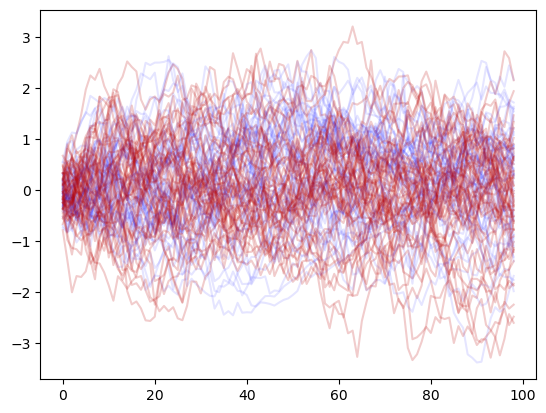

In [12]:
eval_predicted = jax.vmap(lambda datum: model(datum))(
    eval_dataset.transpose(0, 2, 1)
).transpose(0, 2, 1)

plt.plot(eval_predicted[50:100, 0].T, "b", alpha=0.1)
plt.plot(signals[50:100, 1, 1:].T, "#ba0404", alpha=0.2)